# RBIG - Other Transforms

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", True)

import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [132]:
from rbig_jax.data import NoisySineDataset as PlaneDataset
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_samples = 1_000_000
n_features = 2
noise = 0.1
n_train = 10_000
n_valid = 1_000

ds = PlaneDataset(n_samples=n_train, noise=noise, seed=seed)

data = ds[:]

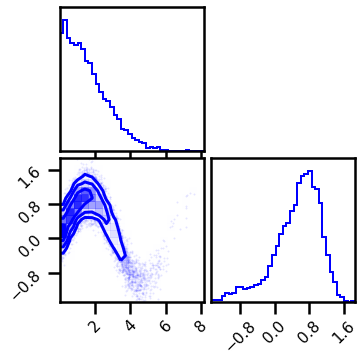

In [133]:
# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

In [134]:
X = jnp.array(data, dtype=np.float64)

## Marginal Uniformization

### Histogram Estimation

In [135]:
from rbig_jax.transforms.histogram import InitUniHistTransform


support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(jnp.sqrt(X.shape[0]))

# initialize histogram transformation
init_hist_f = InitUniHistTransform(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha,
)

### KDE Estimation

In [136]:
from rbig_jax.transforms.kde import InitUniKDETransform

support_extension = 20
precision = 100
bw = "scott"

# initialize histogram transformation
init_kde_f = InitUniKDETransform(
    shape=X.shape, bw=bw, support_extension=support_extension, precision=precision,
)

### Mixture CDF Transformation

In [185]:
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF


# histogram params
n_components = 20
seed = 123
init_method = "gmm"  # "gmm", "random", "kmeans"
key = jax.random.PRNGKey(123)
# initialize
shape = X.shape
n_samples = shape[0]
init_gmm_f = InitMixtureGaussianCDF(
    n_components=n_components, seed=seed, init_method=init_method
)

#### Init Function

Text(0.5, 0.98, 'Forward Transformation')

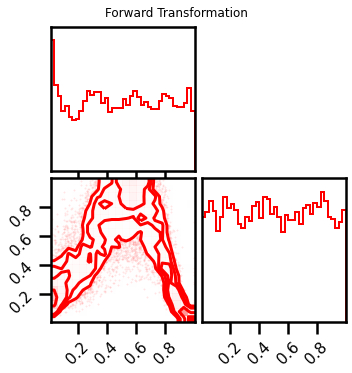

In [138]:
# # plot Transformations
# fig = corner.corner(X, color="red", hist_bin_factor=2)
# fig.suptitle("Original Data")

# initialize bijector
X_u, mcdf_bijector = init_gmm_f.transform_and_bijector(X)

# plot Transformations
fig = corner.corner(X_u, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")

Text(0.5, 0.98, 'Gradient Transformation')

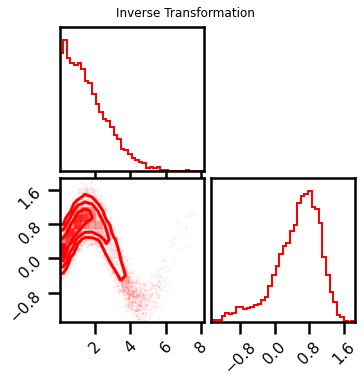

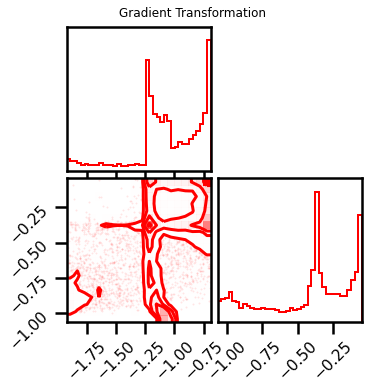

In [139]:
# initialize bijector
X_u, mcdf_bijector = init_gmm_f.transform_and_bijector(
    X, n_features=X.shape[1], rng=key
)

# forward transformation
X_l1 = mcdf_bijector.forward(X)

# inverse transformation
X_approx = mcdf_bijector.inverse(X_l1)

# gradient transformation
X_l1_ldj = mcdf_bijector.forward_log_det_jacobian(X_l1)


fig = corner.corner(X_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")
fig = corner.corner(X_l1_ldj, color="red", hist_bin_factor=2)
fig.suptitle("Gradient Transformation")

### Layer II - Inverse Gaussian CDF

In [140]:
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF

# univariate normalization Gaussianization parameters
eps = 1e-5
jitted = True

# initialize histogram transformation
init_icdf_f = InitInverseGaussCDF(eps=eps, jitted=jitted)

#### Transformations

In [141]:
# forward with bijector
X_l2, icdf_bijector = init_icdf_f.transform_and_bijector(X_l1)

# alternatively - forward with no bijector
X_l2_ = icdf_bijector.forward(X_l1)

chex.assert_tree_all_close(X_l2_, X_l2)

# inverse transformation
X_l1_approx = icdf_bijector.inverse(X_l2)
chex.assert_tree_all_close(X_l1_approx, X_l1, rtol=1e-5)

# gradient transformation
X_l2_ldj = icdf_bijector.forward_log_det_jacobian(X_l1)

Text(0.5, 0.98, 'Gradient Transformation')

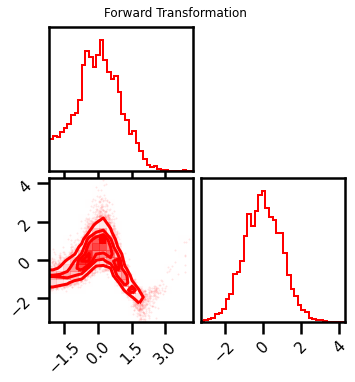

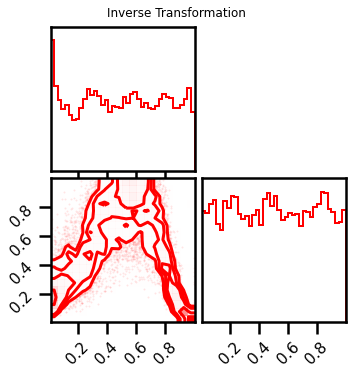

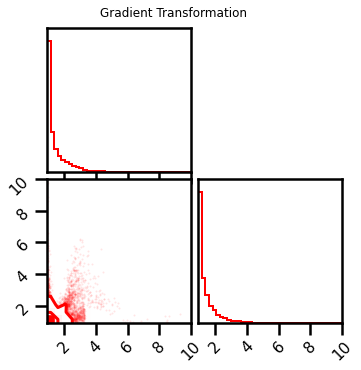

In [142]:
# plot Transformations
fig = corner.corner(X_l2, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_l1_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")
fig = corner.corner(X_l2_ldj, color="red", hist_bin_factor=2)
fig.suptitle("Gradient Transformation")

### Rotation Transformation

#### ICA

In [143]:
from rbig_jax.transforms.rotation import InitICARotation

# initialize histogram transformation
init_ica_f = InitICARotation(jitted=True)

In [144]:
# forward with bijector
X_l3, ica_bijector = init_ica_f.transform_and_bijector(X_l2)

# alternatively - forward with no bijector
X_l3_ = ica_bijector.forward(X_l2)

chex.assert_tree_all_close(X_l3_, X_l3)

# inverse transformation
X_l2_approx = ica_bijector.inverse(X_l3)

chex.assert_tree_all_close(X_l2_approx, X_l2, rtol=1e-3)

# gradient transformation
X_l3_ldj = ica_bijector.forward_log_det_jacobian(X_l2)

chex.assert_tree_all_close(X_l3_ldj, jnp.zeros_like(X_l3_ldj))

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Text(0.5, 0.98, 'Inverse Transformation')

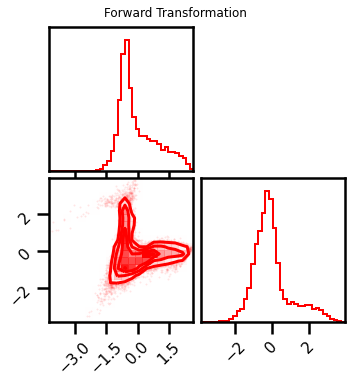

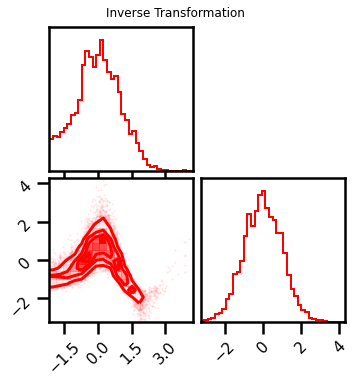

In [145]:
# plot Transformations
fig = corner.corner(X_l3, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_l2_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")

#### PCA Transformation

In [146]:
from rbig_jax.transforms.rotation import InitPCARotation

# initialize histogram transformation
init_pca_f = InitPCARotation(jitted=True)

In [147]:
# forward with bijector
X_l3, pca_bijector = init_pca_f.transform_and_bijector(X_l2)

# alternatively - forward with no bijector
X_l3_ = pca_bijector.forward(X_l2)

chex.assert_tree_all_close(X_l3_, X_l3)

# inverse transformation
X_l2_approx = pca_bijector.inverse(X_l3)

chex.assert_tree_all_close(X_l2_approx, X_l2, rtol=1e-3)

# gradient transformation
X_l3_ldj = pca_bijector.forward_log_det_jacobian(X_l2)

chex.assert_tree_all_close(X_l3_ldj, jnp.zeros_like(X_l3_ldj))

Text(0.5, 0.98, 'Inverse Transformation')

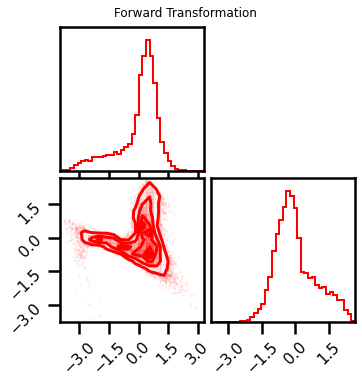

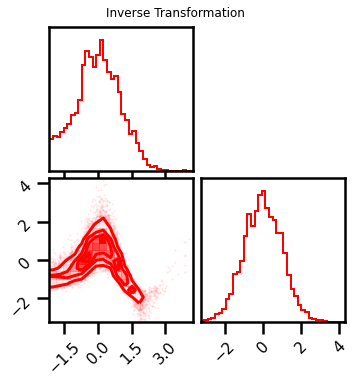

In [148]:
# plot Transformations
fig = corner.corner(X_l3, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_l2_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")

## Squeezing Transformation

In [149]:
from rbig_jax.transforms.inversecdf import InitGaussCDF, InitInverseGaussCDF

jitted = True
init_gcdf_f = InitGaussCDF(jitted=jitted)
init_igcdf_f = InitInverseGaussCDF(jitted=jitted)

## Training (Naive)

In [178]:
from rbig_jax.transforms.block import RBIGBlockInit

In [179]:
%%time

import itertools

itercount = itertools.count(-1)

n_blocks = 20

# initialize rbig block
init_functions = [
#     init_gcdf_f,
#     init_kde_f,
    init_gmm_f,
    init_igcdf_f,
    init_pca_f
]

# initialize RBIG Init Block
rbig_block_init = RBIGBlockInit(init_functions=init_functions)

# initialize list of bijectors
bijectors = list()

# initialize transform
X_g = X.copy()

plot_steps = False

while next(itercount) < n_blocks:
    
    # fit RBIG block
    X_g, ibijector = rbig_block_init.forward_and_bijector(X_g)
    
    if plot_steps:
        fig = corner.corner(X_g, color="blue", hist_bin_factor=2)
    
    # append bijectors 
    bijectors += ibijector

CPU times: user 3min 4s, sys: 2min 40s, total: 5min 44s
Wall time: 14.3 s


#### Check Transformation

Now let's check the Gaussianized data to see how well we did.

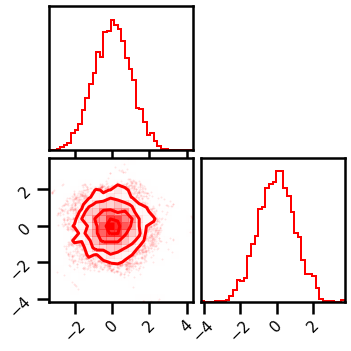

In [180]:
fig = corner.corner(X_g, color="red", hist_bin_factor=2)

This looks pretty good. So let's see how good the inverse transformation. Again, we create a `bijectorchain` which will loop through all of the transformations



## Gaussianization Flow

The bijector chains allow us to do some extra things like density estimation or sampling. So we can also use the `GaussianizationFlow` class which is exactly like the `BijectorChain` class but with some additional benefits like calculating log probabilities. This may seem very redundant for the iterative method, but it is very helpful for fully parameterized Gaussianization; i.e. the end result is the same but the way to find the parameters are different.

In [169]:
from rbig_jax.models import GaussianizationFlow
from distrax._src.distributions.normal import Normal

# initialize base distribution
base_dist = Normal(jnp.zeros((2,)), jnp.ones((2,)))

# initialize flow model
rbig_model = GaussianizationFlow(base_dist=base_dist, bijectors=bijectors)

### Density Estimation

Here we will do an example of density estimation. In this example, 

So here we will do an example of density estimation.
The same pythn code below is equivalent.

```python
# propagate through the chain
X_g_grid, X_ldj_grid = rbig_model.forward_and_log_det(xyinput)

# calculate log prob
base_dist = Normal(jnp.zeros((2,)), jnp.ones((2,)))

latent_prob = base_dist.log_prob(X_g_grid)

# calculate log probability
X_log_prob = latent_prob.sum(axis=1) + X_ldj_grid.sum(axis=1)
```

However, using the `score_samples` method is a lot more convenient.

In [170]:
%%time
from rbig_jax.data import generate_2d_grid

# generate inputs
xyinput = generate_2d_grid(X, 200, buffer=0.1)

X_log_prob = rbig_model.score_samples(xyinput)

CPU times: user 11 s, sys: 1.21 s, total: 12.2 s
Wall time: 2.57 s


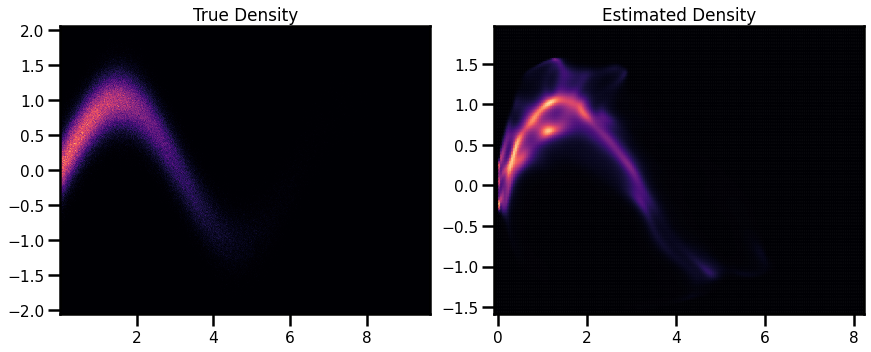

In [171]:
# Original Density
from matplotlib import cm

n_samples = 1_000_000
n_features = 2
ds = PlaneDataset(n_samples=n_samples, seed=42)
X_plot = ds[:]
# X_plot = scaler.transform(X_plot)

# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)


fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)

h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

### Score (Negative Log-Likelihood)


In [172]:
nll = rbig_model.score(X)
print(f"NLL Score: {nll:.4f}")

NLL Score: 1.6994


### Sampling

This is another useful application.

In [173]:
# %%time

# # number of samples
# n_samples = 5_000
# seed = 42

# X_samples = rbig_model.sample(seed=seed, n_samples=n_samples)

In [174]:
# fig = corner.corner(X, color="blue", label="Original Data")
# fig.suptitle("Original Data")
# plt.show()

# fig2 = corner.corner(X_samples, color="purple")
# fig2.suptitle("Generated Samples")
# plt.show()

## Better Training

So we assumed that there would be $20$ layers necessary in order to train the model. But how do we know that it's the best model? This would require some *stopping criteria* instead of just an ad-hoc procedure. 

In RBIG, we use the **information reduction** loss which essentially checks how much information content is being removed with each iteration. We are effectively creating a more and more independent distribution with every marginal Gaussianization + rotation. So naturally, we can simply check how much the information is being reduced between iterations. If there are no changes, we can stop.

#### Loss Function

We can initialize the info loss function here.

In [181]:
from rbig_jax.losses import init_info_loss

# define loss parameters
max_layers = 1_000
zero_tolerance = 60
p = 0.25
base = 2
jitted = True

# initialize info loss function
loss = init_info_loss(
    n_samples=X.shape[0],
    max_layers=max_layers,
    zero_tolerance=zero_tolerance,
    p=p,
    base=base,
    jitted=jitted,
)

#### Training

In [182]:
from rbig_jax.training.iterative import train_info_loss_model

# define training params
verbose = True
n_layers_remove = 50
interval = 10

# run iterative training
X_g, rbig_model_info = train_info_loss_model(
    X=X,
    rbig_block_init=rbig_block_init,
    loss=loss,
    verbose=verbose,
    interval=interval,
    n_layers_remove=n_layers_remove,
)

Layer 10 - Cum. Info Reduction: 1.434 - Elapsed Time: 8.5284 secs
Layer 20 - Cum. Info Reduction: 1.453 - Elapsed Time: 14.6802 secs
Layer 30 - Cum. Info Reduction: 1.467 - Elapsed Time: 21.3069 secs
Layer 40 - Cum. Info Reduction: 1.467 - Elapsed Time: 28.3142 secs
Layer 50 - Cum. Info Reduction: 1.467 - Elapsed Time: 35.6407 secs
Layer 60 - Cum. Info Reduction: 1.497 - Elapsed Time: 42.6911 secs
Layer 70 - Cum. Info Reduction: 1.512 - Elapsed Time: 49.6928 secs
Layer 80 - Cum. Info Reduction: 1.547 - Elapsed Time: 56.4256 secs
Layer 90 - Cum. Info Reduction: 1.557 - Elapsed Time: 63.4948 secs
Layer 100 - Cum. Info Reduction: 1.557 - Elapsed Time: 70.0925 secs
Layer 110 - Cum. Info Reduction: 1.575 - Elapsed Time: 77.3027 secs



KeyboardInterrupt

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


Layer 120 - Cum. Info Reduction: 1.575 - Elapsed Time: 84.0494 secs


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


Layer 130 - Cum. Info Reduction: 1.575 - Elapsed Time: 90.7182 secs
Layer 140 - Cum. Info Reduction: 1.593 - Elapsed Time: 97.5568 secs


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


Layer 150 - Cum. Info Reduction: 1.593 - Elapsed Time: 104.5996 secs
Layer 160 - Cum. Info Reduction: 1.599 - Elapsed Time: 111.6108 secs
Layer 170 - Cum. Info Reduction: 1.599 - Elapsed Time: 118.9928 secs
Layer 180 - Cum. Info Reduction: 1.599 - Elapsed Time: 125.9512 secs
Layer 190 - Cum. Info Reduction: 1.599 - Elapsed Time: 132.9529 secs
Layer 200 - Cum. Info Reduction: 1.603 - Elapsed Time: 139.0819 secs
Layer 210 - Cum. Info Reduction: 1.603 - Elapsed Time: 145.8529 secs
Layer 220 - Cum. Info Reduction: 1.603 - Elapsed Time: 152.8279 secs
Layer 230 - Cum. Info Reduction: 1.628 - Elapsed Time: 159.5210 secs
Layer 240 - Cum. Info Reduction: 1.628 - Elapsed Time: 166.5430 secs
Layer 250 - Cum. Info Reduction: 1.643 - Elapsed Time: 173.2743 secs
Layer 260 - Cum. Info Reduction: 1.665 - Elapsed Time: 180.2288 secs
Layer 270 - Cum. Info Reduction: 1.665 - Elapsed Time: 187.3691 secs
Layer 280 - Cum. Info Reduction: 1.680 - Elapsed Time: 194.4268 secs
Layer 290 - Cum. Info Reduction: 1

#### Information Reduction Evolution

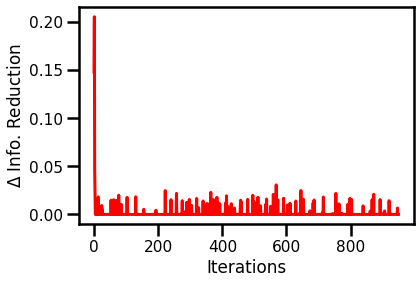

In [183]:
fig, ax = plt.subplots()
ax.plot(rbig_model_info.info_loss, color="red")
ax.set(xlabel="Iterations", ylabel="$\Delta$ Info. Reduction")
plt.show()

#### Negative Log-Likelihood

In [184]:
nll = rbig_model_info.score(X)
print(f"NLL Score: {nll:.4f}")

NLL Score: 3.7481


#### Density Estimation (Revisited)

In [163]:
from rbig_jax.data import generate_2d_grid

# generate inputs
xyinput = generate_2d_grid(X, 200, buffer=0.1)

X_log_prob = rbig_model_info.score_samples(xyinput)

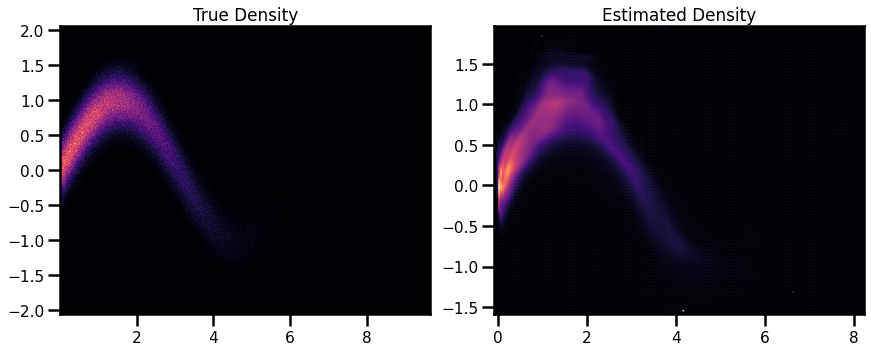

In [164]:
# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)


fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)

h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

#### Sampling Revisited

In [165]:
%%time

# number of samples
n_samples = 100_000
seed = 42

X_samples = rbig_model_info.sample(seed=seed, n_samples=n_samples)

CPU times: user 8.53 s, sys: 550 ms, total: 9.08 s
Wall time: 2.61 s


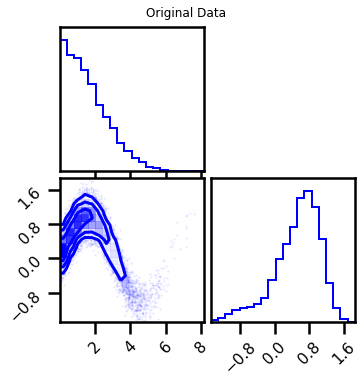

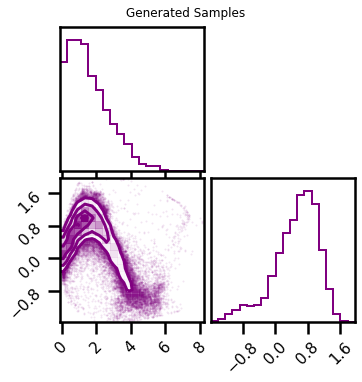

In [166]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Saving and Loading

Often times it would be nice to save and load models. This is useful for checkpointing (during training) and also for convenience if you're doing research on google colab.

Fortunately, everything here are python objects, so we can easily save and load our models via `pickle`.

#### Saving

Do to the internals of python (and design choices within this library), one can only store `objects`. So that includes the `rbig_block`, the `bijectors` and also the `rbig_model`. This does not include the `rbig_block_init` for example because that isn't an object, it's a function with some local params.

In [94]:
import pickle

# # save the blocks
# with open("rbig_block.pickle", "wb") as f:
#     pickle.dump(rbig_block, f)

# # save the bijectors
# with open("bijectors.pickle", "wb") as f:
#     pickle.dump(bijectors, f)

# save the full model
import joblib

joblib.dump(rbig_model_info, "rbig_model_gmm.pickle")

['rbig_model_gmm.pickle']

#### Loading

Loading is straight forward!

In [95]:
rbig_model_loaded = joblib.load("rbig_model_gmm.pickle")

#### Simple Test

They won't be the **exact same** byte-for-byte encoding. But they should give the same results either way :).

In [96]:
# nll for the old model
nll = rbig_model_info.score(X)
print(f"Negative Log-Likelihood: {nll:.4f}")

# nll for the loaded model
nll = rbig_model_loaded.score(X)
print(f"Negative Log-Likelihood: {nll:.4f}")

Negative Log-Likelihood: 1.6370
Negative Log-Likelihood: 1.6370
